# Hold-out

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from rapidfuzz import fuzz, process

import scipy.stats as stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import category_encoders as ce

### read csv

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Data Quality check

In [4]:
train.head(3)

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.0,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.0,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.0,0.0


In [5]:
train.duplicated("carID").sum()

0

No carID duplicated, so we can put as index.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


We can conclude that we have many strange values in all columns and some Dtypes are wrong (year;previousOwners).

In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
carID,75973.0,37986.000000,21931.660338,0.000000,18993.00,37986.0,56979.0,75972.000000
year,74482.0,2017.096611,2.208704,1970.000000,2016.00,2017.0,2019.0,2024.121759
price,75973.0,16881.889553,9736.926322,450.000000,10200.00,14699.0,20950.0,159999.000000
mileage,74510.0,23004.184088,22129.788366,-58540.574478,7423.25,17300.0,32427.5,323000.000000
tax,68069.0,120.329078,65.521176,-91.121630,125.00,145.0,145.0,580.000000
mpg,68047.0,55.152666,16.497837,-43.421768,46.30,54.3,62.8,470.800000
engineSize,74457.0,1.660136,0.573462,-0.103493,1.20,1.6,2.0,6.600000
paintQuality%,74449.0,64.590667,21.021065,1.638913,47.00,65.0,82.0,125.594308
previousOwners,74423.0,1.994580,1.472981,-2.345650,1.00,2.0,3.0,6.258371
hasDamage,74425.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000000


In [8]:
metric_features = ['year', 'mileage','tax','mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage']
non_metric_features = train.columns.drop(metric_features).to_list()
non_metric_features.remove("carID")
non_metric_features.remove("price")

##### Here we can detect many strange values as:
    2024.121759 in the year column;
    -58540.574478 in the mileage column;
    -91.121630 in the tax column;
    -43.421768 in the mpg column;
    -0.103493 in the engineSize column;
    125.594308 in the paintQuality% column;
    -2.345650 in the previousOwners column;
    just zeros in the hasDamage column.

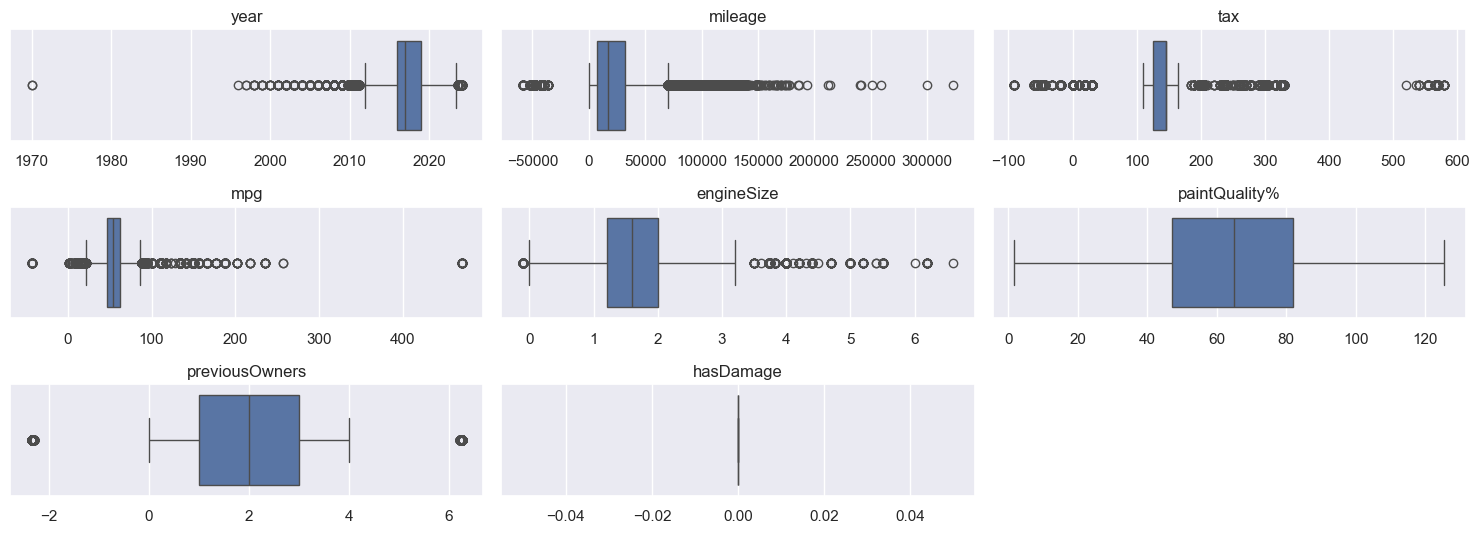

In [9]:
plt.figure(figsize=(15, 7))
for i, col in enumerate(metric_features):
    plt.subplot(4, 3, i + 1) # Cria uma grelha 2x2
    sns.boxplot(x=train[col])
    plt.title(col)
    plt.xlabel("")

plt.tight_layout()
plt.show()

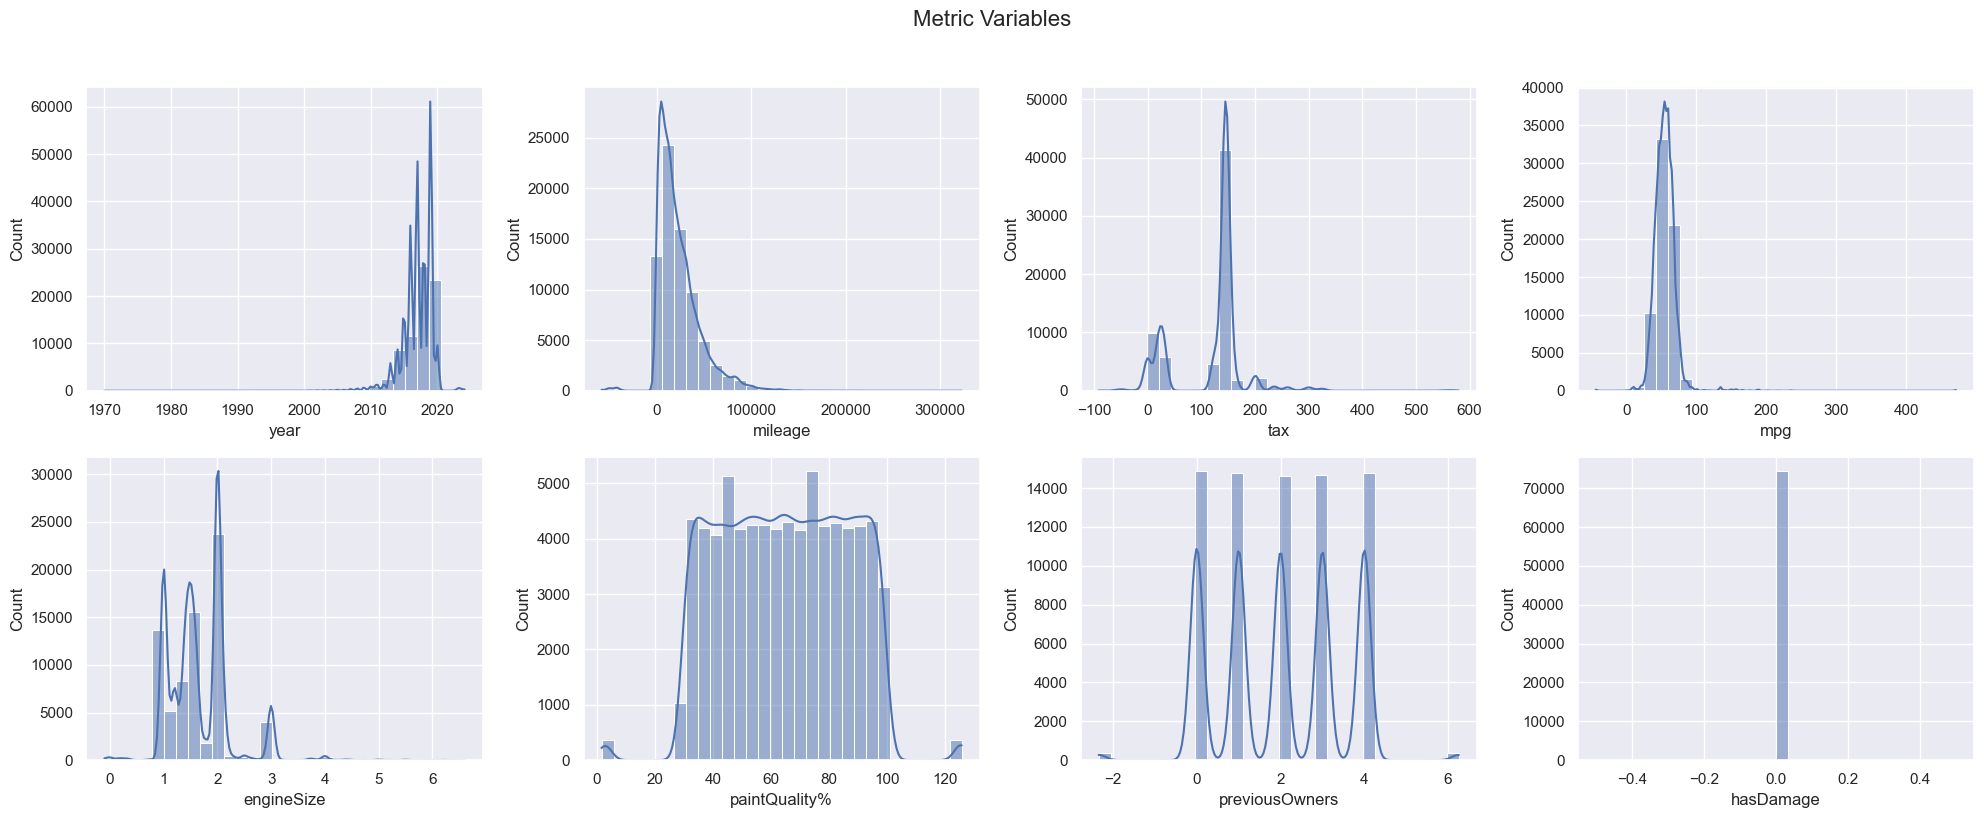

In [10]:
sp_rows = 2
sp_cols = 4

# Prepare figure and axes
fig, axes = plt.subplots(sp_rows, sp_cols, figsize=(20, 8), tight_layout=True)

# Plot data with seaborn
features = [f for f in metric_features]

for ax, feat in zip(axes.flatten(), features):
    sns.histplot(train[feat], bins=30, kde=True, ax=ax)

# Add a centered title to the figure
title = "Metric Variables"
fig.suptitle(title, fontsize=16, y=1.02)

plt.show()


From the histograms, I can observe that most of the metric variables are right-skewed and contain several outliers. Because of this non-normal distribution, replacing missing values (NaNs) with the median is more appropriate than using the mean, as the median is less affected by extreme values and better represents the central tendency of skewed data.

In [11]:
print(train.isna().sum())

carID                0
Brand             1521
model             1517
year              1491
price                0
transmission      1522
mileage           1463
fuelType          1511
tax               7904
mpg               7926
engineSize        1516
paintQuality%     1524
previousOwners    1550
hasDamage         1548
dtype: int64


In [12]:
train.hasDamage.value_counts()

hasDamage
0.0    74425
Name: count, dtype: int64

By looking at this result, we can conclude that the stand only sells cars that have no damage at all

# Pre Processing 

## Metric variables

In [13]:
def strange_values_to_nan(f,column,limit):
    strange_values = f[column] < limit
    f.loc[strange_values, column] = np.nan 
    print(f"Found {strange_values.sum()} strange values in {column}.")

In [14]:
def pre_processing_metric(df):
    #setting carID as index
    df.set_index("carID", inplace=True)

    #fixing the types
    df["year"]=[int(i) if isinstance(i, float) and not pd.isna(i) else i for i in df["year"]]
    df["year"] = df["year"].astype("Int64")
    df["previousOwners"]=[int(i) if isinstance(i, float) and not pd.isna(i) else i for i in df["previousOwners"]]
    df["previousOwners"] = df["previousOwners"].astype("Int64")

    #converting strange values to nan
    strange_values_to_nan(df,"mileage",0)
    strange_values_to_nan(df,"tax",0)
    strange_values_to_nan(df,"mpg",10)
    strange_values_to_nan(df,"engineSize",1)
    strange_values_to_nan(df,"previousOwners",0)
    df.loc[df["paintQuality%"] > 100, "paintQuality%"] = np.nan 

    #deleting column hasDamage because it has the same value in all rows
    del df["hasDamage"]
        

In [15]:
metric_features.remove("hasDamage") #removing hasDamage from metric_features list, because we deleted this column.

In [16]:
X=[train,test]

In [17]:
for f in X:
    pre_processing_metric(f)

Found 369 strange values in mileage.
Found 378 strange values in tax.
Found 151 strange values in mpg.
Found 574 strange values in engineSize.
Found 371 strange values in previousOwners.
Found 170 strange values in mileage.
Found 161 strange values in tax.
Found 74 strange values in mpg.
Found 245 strange values in engineSize.
Found 168 strange values in previousOwners.


In [18]:
train.head(3)

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners
carID,,,,,,,,,,,,
69512,VW,Golf,2016,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4
53000,Toyota,Yaris,2019,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1
6366,Audi,Q2,2019,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4


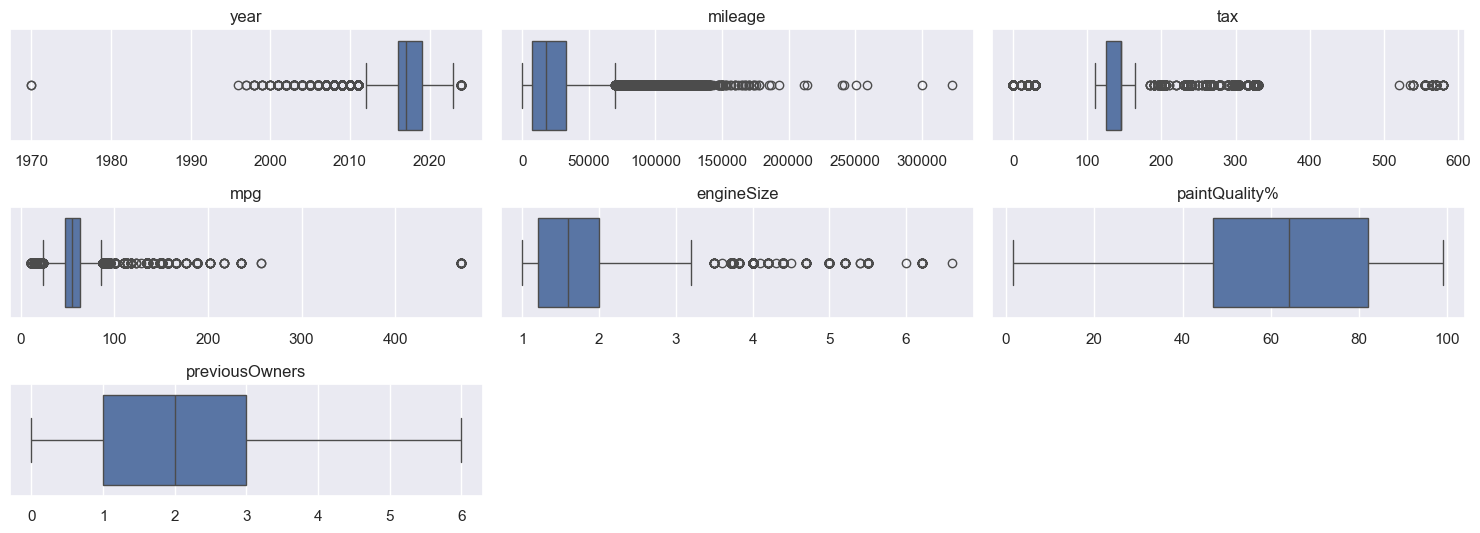

In [19]:
plt.figure(figsize=(15, 7))
for i, col in enumerate(metric_features):
    plt.subplot(4, 3, i + 1) # Cria uma grelha 2x2
    sns.boxplot(x=train[col])
    plt.title(col)
    plt.xlabel("")

plt.tight_layout()
plt.show()

### Non Metric variables

In [64]:
def build_valid_dic(column, valid_list, cuttoff):
    #first, clean de column and the valid list
    unique_column_values = [str(v).strip().lower() for v in column.dropna().unique()]
    #secound, creat the dic with the valid values with empyt similar words
    result = {valid_word: [] for valid_word in valid_list}

    for valid in valid_list:
        valid_lower = valid.lower()
        fuzzy_matched_values = process.extract(
            valid_lower, #the check valeu
            unique_column_values, #the list that we are going to use to check
            scorer = fuzz.token_sort_ratio,
            score_cutoff = cuttoff
        )
        for match_value, score, _ in fuzzy_matched_values:
            if match_value != valid_lower:
                result[valid].append(match_value)

    return result


def replace_invalid_values(column, valid_dic):
    corrected = []
    for val in column:
        if pd.isna(val):
            corrected.append(val)
            continue
        valeu_cleaned = str(val).strip().lower()
        found = False
        for key in valid_dic:
            if valeu_cleaned == key.lower():
                corrected.append(key)
                found = True
                break
        if not found:
            for valid_key, variations in valid_dic.items():
                if valeu_cleaned in [v.lower() for v in variations]:
                    corrected.append(valid_key)
                    found = True
                    break
        if not found:
            corrected.append(val)

    return corrected
def fill_nans_categorical(data, columns):
    for col in columns:
        data[col] =data[col].fillna("Unknown")
    return data


def dic_brand_modles(brands, models, valid_brands):
    result = {brand: [] for brand in valid_brands}
    for brand, model in zip(brands,models):
        if pd.isna(brand) or pd.isna(model):
            continue
        model_clean = str(model).strip().lower()
        if model_clean not in result[brand]:
            result[brand].append(model_clean)

    return result

def pre_processing_non_metric(dic_col_valid, data):
    for i in range(1,4):
        for key,values in dic_col_valid.items():
            valid_dic = build_valid_dic(data[key],values, cuttoff= 50)
            data[key] = replace_invalid_values(data[key], valid_dic)
            if i == 3:
                print(data[key].value_counts())
                
                
def valid_models_dict(data, brands, min_count=0):
    models_dict = {}
    for brand in brands:
        brands_frame = data[data["Brand"] == brand]
        models_clean = brands_frame["model"].astype(str).str.strip().str.lower()
        models_count = models_clean.value_counts()
        models_count = models_count[models_count >= min_count]
        potential_models = models_count.index.tolist()
        valid_models_for_brand = []

        for model in potential_models:
            is_truncated = False
            for valid_model in valid_models_for_brand:
                if valid_model.startswith(model):
                   
                    is_truncated = True
                    break

            if not is_truncated:
                valid_models_for_brand.append(model)

        models_dict[brand] = valid_models_for_brand

    return models_dict

def fill_unknown_brand(data,valid_models_dict):
    unknown_df = data[data['Brand'] == 'Unknown']
    for idx,row in unknown_df.iterrows():
        model_lower = str(row['model']).lower()
        for brand, models in valid_models_dict.items():
            if model_lower in [m.lower() for m in models]: 
                data.at[idx, 'Brand'] = brand
                break 

    return data
        

In [21]:
valid_brands_list = ["Ford", "Mercedes", "VW", "Opel", "BMW", "Audi", "Toyota","Skoda", "Hyundai", "Unknown"]
valid_transmition_list = ["Manual", "Semi-Auto", "Automatic", "Other", "Unknown"]
valid_fueltype_list = ["Petrol" ,"Diesel", "Hybrid" , "Other", "Electric", "Unknown"]
cols_change_dic = {"Brand" : valid_brands_list,
                   "transmission" : valid_transmition_list,
                   "fuelType" : valid_fueltype_list
                   }

In [22]:
for f in X:
    fill_nans_categorical(f, non_metric_features)
    pre_processing_non_metric(cols_change_dic, f)

Brand
Ford        16065
Mercedes    11674
VW          10385
Opel         9352
BMW          7392
Audi         7325
Toyota       4622
Skoda        4301
Hyundai      3336
Unknown      1521
Name: count, dtype: int64
transmission
Manual       41627
Semi-Auto    16872
Automatic    15211
Unknown       2258
Other            5
Name: count, dtype: int64
fuelType
Petrol      41163
Diesel      30885
Hybrid       2225
Unknown      1511
Other         167
Electric       22
Name: count, dtype: int64
Brand
Ford        6891
Mercedes    5004
VW          4466
Opel        4008
BMW         3174
Audi        3130
Toyota      1982
Skoda       1836
Hyundai     1427
Unknown      649
Name: count, dtype: int64
transmission
Manual       17889
Semi-Auto     7267
Automatic     6440
Unknown        968
Other            3
Name: count, dtype: int64
fuelType
Petrol      17488
Diesel      13395
Hybrid        936
Unknown       656
Other          82
Electric       10
Name: count, dtype: int64


In [57]:
valid_models = valid_models_dict(train,valid_brands_list)

{'Ford': ['focus', 'fiesta', 'kuga', 'ecosport', 'c-max', 'ka+', 'mondeo', 'unknown', 'b-max', 's-max', 'grand c-max', 'galaxy', 'edge', 'puma', 'tourneo custom', 'grand tourneo connect', 'mustang', 'tourneo connect', 'fusion', 'streetka', 'fabia', 'escort', 'ranger', 'octavia'], 'Mercedes': ['c class', 'a class', 'e class', 'glc class', 'gla class', 'b class', 'cl class', 'gle class', 'unknown', 'sl class', 'cls class', 'v class', 's class', 'gl class', 'slk', 'cla class', 'x-class', 'gls class', 'm class', 'glb class', 'g class', 'clk', '200', '220', '230', 'clc class'], 'VW': ['golf', 'polo', 'tiguan', 'passat', 'up', 't-roc', 'touareg', 'touran', 't-cross', 'unknown', 'golf sv', 'sharan', 'arteon', 'scirocco', 'amarok', 'caravelle', 'tiguan allspace', 'cc', 'beetle', 'caddy maxi life', 'shuttle', 'jetta', 'california', 'caddy life', 'eos', 'fox'], 'Opel': ['corsa', 'mokka x', 'astra', 'insignia', 'crossland x', 'zafira', 'grandland x', 'adam', 'viva', 'unknown', 'meriva', 'combo li

In [24]:
for f in X:
    for brand ,valid_models_list in valid_models.items():
        brand_rows = f[f["Brand"] == brand]
        pre_processing_non_metric({"model": valid_models_list}, brand_rows)
        f.loc[brand_rows.index, "model"] = brand_rows["model"]

model
focus                    6756
fiesta                   4396
kuga                     1628
ecosport                  803
c-max                     378
ka+                       354
mondeo                    345
unknown                   324
b-max                     243
s-max                     197
grand c-max               147
galaxy                    143
edge                      134
puma                       51
tourneo custom             50
grand tourneo connect      41
mustang                    37
tourneo connect            20
fusion                     12
streetka                    2
fabia                       1
escort                      1
ranger                      1
octavia                     1
Name: count, dtype: int64
model
c class      5189
a class      1694
e class      1286
glc class     657
gla class     547
b class       412
cl class      324
gle class     322
unknown       230
sl class      177
cls class     153
v class       136
s class       129
gl class

In [65]:
for f in X:
    f = fill_unknown_brand(f,valid_models)

In [66]:
#train[train["Brand"] == "Unknown"]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners
carID,,,,,,,,,,,,


### SPLIT THE DATA

In [26]:
X_train_val = train.drop('price', axis=1) 
y_train_val = train['price']
X_test = test.copy()


In [27]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val, 
    test_size=0.25, 
    random_state=21,
    shuffle=True
)

In [28]:
print('train:{}% | validation:{}%'.format(round(len(y_train)/len(y_train_val),2),
                                                     round(len(y_val)/len(y_train_val),2),))

train:0.75% | validation:0.25%


In [29]:
X_features = [X_train, X_val, X_test]

### impute median

In [30]:
def impute_numeric_features(X_features_list, metric_features):

    imputer = SimpleImputer(strategy='median')
    
    X_train_numeric_to_fit = X_features_list[0][metric_features]
    
    imputer.fit(X_train_numeric_to_fit)
    
    imputed_dfs_list = []
    
    for df in X_features_list:
    
        df_copy = df.copy() 
        
        # Aplicar a imputação (transform) SÓ nas colunas numéricas
        # O .transform() devolve um array NumPy, por isso temos de o recolocar
        imputed_data_np = imputer.transform(df_copy[metric_features])
        
        # Recolocar os dados imputados no DataFrame (preserva o índice)
        df_copy[metric_features] = imputed_data_np
        
        # Adicionar o DataFrame modificado à nova lista
        imputed_dfs_list.append(df_copy)
    return imputed_dfs_list

X_features_imputed=impute_numeric_features(X_features,metric_features)

### Scalling

In [31]:
#def scale_numeric_features(X_features, metric_features):

    #scaler = MinMaxScaler()

    # Fitting the scaler only on the train data
    #X_train = X_features[0].copy()
    #scaler.fit(X_train[metric_features])

    #scaled_features_list =[]

    #for i,X, in enumerate(X_features):
        #X_scaled = X.copy()
        #X_scaled[metric_features] = scaler.transform(X[metric_features])
        #scaled_features_list.append(X_scaled)

    #return scaled_features_list

#X_train_scaled, X_val_scaled, X_test_scaled = scale_numeric_features(X_features, metric_features )

#X_train_num_scaled = X_train_scaled[metric_features]
#X_val_num_scaled = X_val_scaled[metric_features]

#print(X_train_num_scaled.min())
#print(X_train_num_scaled.max())

In [32]:
def scale_numeric_features(X_features, metric_features):


    scaler = RobustScaler() 

    # Fitting the scaler only on the train data
    X_train = X_features[0].copy()
    scaler.fit(X_train[metric_features])

    
    scaled_features_list =[]

    for i,X, in enumerate(X_features):
        X_scaled = X.copy()
        X_scaled[metric_features] = scaler.transform(X[metric_features])
        scaled_features_list.append(X_scaled)

    return scaled_features_list
X_train_scaled, X_val_scaled, X_test_scaled = scale_numeric_features(X_features_imputed, metric_features)
X_features_scaled=[X_train_scaled, X_val_scaled, X_test_scaled]
X_train_num_scaled = X_train_scaled[metric_features]
X_val_num_scaled = X_val_scaled[metric_features]

print(X_train_num_scaled.min())
print(X_train_num_scaled.max())

year             -15.666667
mileage           -0.717806
tax               -7.250000
mpg               -3.176499
engineSize        -0.857143
paintQuality%     -1.781745
previousOwners    -1.000000
dtype: float64
year               2.333333
mileage           11.581772
tax               21.750000
mpg               30.851852
engineSize         7.142857
paintQuality%      1.000000
previousOwners     2.000000
dtype: float64


# Feature Selection

In [33]:
X_train_num_scaled[metric_features].var()

year              0.528838
mileage           0.776598
tax               9.499812
mpg               1.364956
engineSize        0.624427
paintQuality%     0.338452
previousOwners    0.505882
dtype: float64

### Spearman Correlation

In [34]:
cor_spearman = X_train_num_scaled.corr(method ='spearman')
cor_spearman

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners
year,1.000000,-0.769962,0.303271,-0.294803,-0.040770,0.004020,0.004372
mileage,-0.769962,1.000000,-0.243356,0.305451,0.102233,-0.002679,-0.000446
tax,0.303271,-0.243356,1.000000,-0.540430,0.148026,0.001716,0.000523
mpg,-0.294803,0.305451,-0.540430,1.000000,-0.181478,0.001428,-0.000899
engineSize,-0.040770,0.102233,0.148026,-0.181478,1.000000,-0.000357,0.000020
paintQuality%,0.004020,-0.002679,0.001716,0.001428,-0.000357,1.000000,-0.005251
previousOwners,0.004372,-0.000446,0.000523,-0.000899,0.000020,-0.005251,1.000000


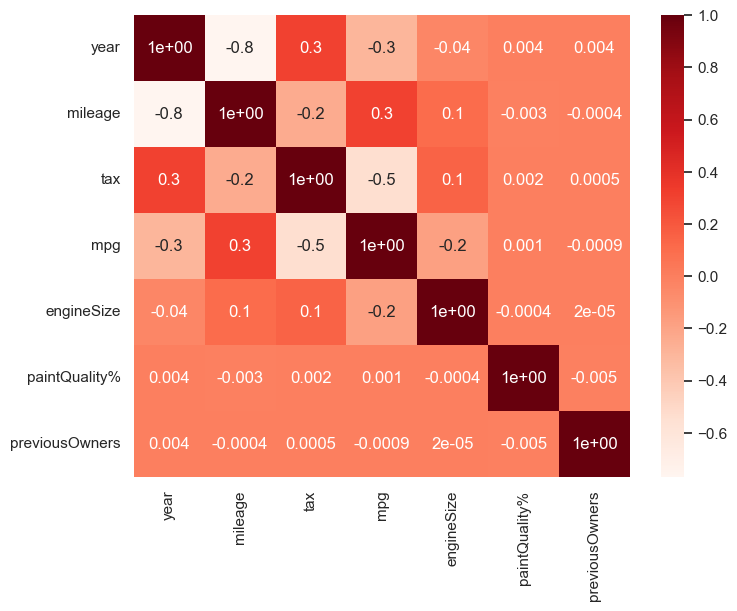

In [35]:
def cor_heatmap(cor):
    plt.figure(figsize=(8,6))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

cor_heatmap (cor_spearman)

### Chi2

In [36]:
def testindependence1(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [37]:
X_train_cat=X_train_scaled[non_metric_features]
for var in X_train_cat:
    testindependence1(X_train_cat[var],y_train, var)

Brand is IMPORTANT for Prediction
model is IMPORTANT for Prediction
transmission is IMPORTANT for Prediction
fuelType is IMPORTANT for Prediction


### Linear Regression

In [38]:
#no of features
nof_list=np.arange(1,len(X_train_num_scaled.columns)+1)            
high_score=0
#Variable to store the optimum features
nof=0           
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):
    #call support vector machines classifier
    model = LinearRegression()
    
    #create RFE instance
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    
    #fit and transform for training data, transform for val data
    X_train_rfe = rfe.fit_transform(X_train_num_scaled,y_train)
    X_val_rfe = rfe.transform(X_val_num_scaled)
    
    model.fit(X_train_rfe,y_train)
    
    #storing results on training data
    train_score = model.score(X_train_rfe,y_train)
    train_score_list.append(train_score)
    
    #storing results on validation data
    val_score = model.score(X_val_rfe,y_val)
    val_score_list.append(val_score)
    
    #check best score
    if(val_score > high_score):
        high_score = val_score
        nof = nof_list[n]
        
        #adding mention of variables to keep
        features_to_select = pd.Series(rfe.support_, index = X_train_num_scaled.columns)
        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")

Optimum number of features: 7
Score with 7 features: 0.686295
Features to select: 
year              True
mileage           True
tax               True
mpg               True
engineSize        True
paintQuality%     True
previousOwners    True
dtype: bool


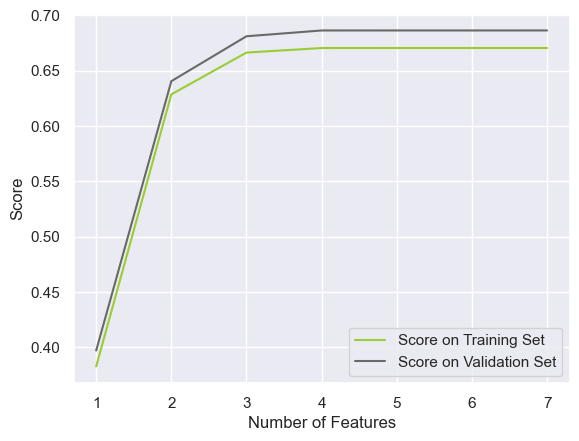

In [39]:
plt.plot(list(range(1,8)), train_score_list, label="Score on Training Set", color='yellowgreen')
plt.plot(list(range(1,8)), val_score_list, label="Score on Validation Set", color='dimgray')
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.legend()
plt.show()

### Lasso Regression 

Lasso picked 6 variables and eliminated the other 1 variables
mileage          -2775.179602
mpg               -547.508683
paintQuality%      -21.611668
previousOwners       0.000000
tax                  0.940017
year              4267.664744
engineSize        7957.383889
dtype: float64


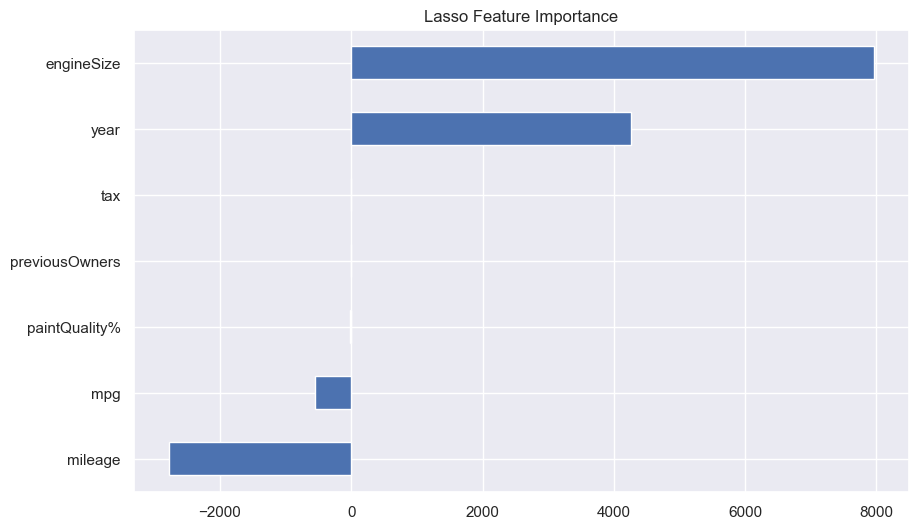

In [40]:
from sklearn.linear_model import LassoCV

# Função para plotar importância das features
def plot_importance(coef, title):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(10,6))
    imp_coef.plot(kind="barh")
    plt.title(title)
    plt.show()

# Separar as features numéricas escaladas
numeric_cols = metric_features  # as que escalaste
X_train_num_scaled = X_train_scaled[numeric_cols]

# LassoCV
reg = LassoCV(cv=5, random_state=42)
reg.fit(X_train_num_scaled, y_train)

# Coeficientes
coef = pd.Series(reg.coef_, index = X_train_num_scaled.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " + str(sum(coef == 0)) + " variables")
print(coef.sort_values())

# Plot
plot_importance(coef, "Lasso Feature Importance")

### Results and conclusions

<font color=#00A36C>Numerical Features</font>

| Predictor       | Spearman | RFE Linear | Lasso  | What to do? |
|-----------------|----------|------------|--------|-------------|
| year            | Keep     | Keep       | Keep   | Include in the model |
| mileage         | Keep     | Keep       | Keep   | Include in the model |
| tax             | Keep     | Discard    | Keep   | Discard |
| mpg             | Keep     | Keep       | Keep   | Include in the model |
| engineSize      | Keep     | Keep       | Keep   | Include in the model |
| paintQuality%   | Keep     | Discard    | Keep   | Discard              |
| previousOwners  | Keep     | Discard    | Discard| Discard |

 <font color=#00A36C>Categorical Features</font>

| Predictor       | Chi-Square Result                | What do |
|-----------------|----------------------------------| -- |
| Brand           | Keep                             | Include in the model |
| model           | Keep                             | Include in the model |
| transmission    | Keep                             | Include in the model |
| fuelType        | Keep                             | Include in the model |

In [41]:
def remove_columns(dfs):
    columns_to_remove=["tax","paintQuality%","previousOwners"]
    for X in dfs:
        X=X.drop(columns_to_remove, axis=1, inplace=True)
    return dfs

In [42]:
remove_columns(X_features_scaled)

[          Brand            model      year transmission   mileage fuelType  \
 carID                                                                        
 63749      Opel          mokka x  0.666667       Manual -0.097987   Petrol   
 7908        BMW         5 series  0.666667    Automatic -0.655365   Hybrid   
 2960       Audi               a1 -0.333333       Manual  0.797097   Petrol   
 13623       BMW         2 series  0.666667    Semi-Auto -0.717232   Petrol   
 37456  Mercedes          b class  0.333333    Automatic -0.423845   Petrol   
 ...         ...              ...       ...          ...       ...      ...   
 69041        VW  tiguan allspace  1.000000       Manual -0.701160   Diesel   
 31633   Hyundai             kona  0.666667    Semi-Auto -0.534951   Diesel   
 36916  Mercedes          c class  0.666667    Semi-Auto -0.279324   Petrol   
 4922       Audi               q5  0.666667    Automatic -0.427658   Diesel   
 74552        VW             polo -0.333333       Ma

# Encoding

In [43]:
from sklearn.preprocessing import OrdinalEncoder
def aplicar_ordinal_encoder(X_train, X_val,X_test):
    """
    Aplica o OrdinalEncoder manualmente, aprendendo apenas no X_train
    para evitar data leakage.
    
    Trata valores desconhecidos (que aparecem no X_test mas não no X_train)
    atribuindo-lhes o valor -1.
    
    Args:
        X_train (pd.DataFrame): DataFrame de treino (apenas colunas categóricas).
        X_test (pd.DataFrame): DataFrame de teste (apenas colunas categóricas).
        
    Returns:
        tuple: (X_train_encoded, X_test_encoded) como arrays NumPy.
    """
    
    # 1. Inicializar o Encoder
    # handle_unknown='use_encoded_value' diz-lhe para usar o unknown_value
    # unknown_value=-1 é o valor que será atribuído a categorias "novas"
    encoder = OrdinalEncoder(
        handle_unknown='use_encoded_value', 
        unknown_value=-1,
        dtype=int
    )
    
    # 2. Aprender (fit) as categorias APENAS nos dados de TREINO
    encoder.fit(X_train)
    
    # Mostrar as categorias aprendidas (opcional, mas útil)
    for i, col in enumerate(X_train.columns):
        print(f"  {col}: {encoder.categories_[i]}")
    
    # 3. Transformar (transform) AMBOS os conjuntos

    X_train_encoded = encoder.transform(X_train)
    

    X_val_encoded = encoder.transform(X_val)
    X_test_encoded = encoder.transform(X_test)
    
    return X_train_encoded, X_val_encoded, X_test_encoded

In [44]:
X_train_encoded, X_val_encoded, X_test_encoded=aplicar_ordinal_encoder(X_train_scaled,X_val_scaled,X_test_scaled)


  Brand: ['Audi' 'BMW' 'Ford' 'Hyundai' 'Mercedes' 'Opel' 'Skoda' 'Toyota'
 'Unknown' 'VW']
  model: [' Yet' '1 series' '2 series' '200' '230' '3 series' '4 series' '5 series'
 '6 series' '7 series' '8 series' 'a class' 'a1' 'a3' 'a4' 'a5' 'a6' 'a7'
 'a8' 'adam' 'agila' 'amarok' 'ampera' 'antara' 'arteon' 'astra' 'auris'
 'avensis' 'aygo' 'b class' 'b-max' 'beetle' 'c class' 'c-hr' 'c-max'
 'caddy life' 'caddy maxi life' 'california' 'camry' 'caravelle' 'cascada'
 'cc' 'citigo' 'cl class' 'cla class' 'clk' 'cls class' 'combo life'
 'corolla' 'corsa' 'crossland x' 'e class' 'ecosport' 'edge' 'eos' 'fabia'
 'fiesta' 'focus' 'fusion' 'g class' 'galaxy' 'getz' 'gl class'
 'gla class' 'glb class' 'glc class' 'gle class' 'gls class' 'golf'
 'golf sv' 'grand c-max' 'grand tourneo connect' 'grandland x' 'gt86'
 'gtc' 'hilux' 'i10' 'i20' 'i3' 'i30' 'i40' 'i8' 'i800' 'insignia' 'ioniq'
 'iq' 'ix20' 'ix35' 'jetta' 'ka+' 'kadjar' 'kamiq' 'karoq' 'kodiaq' 'kona'
 'kuga' 'land cruiser' 'm class' 'm2

### Model Evaluation

In [45]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(alpha=0.1, random_state=42), 
    "Ridge": Ridge(alpha=0.1, random_state=42),
    "Linear SVR": LinearSVR(random_state=42, max_iter=3000, dual="auto"), 
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, max_depth=18, max_features= 0.7,min_samples_leaf= 5,min_samples_split= 10) 
}
results = {}

In [46]:
def running_models(X_train,y_train,X_val,y_val):
    for name, model in models.items():
        #training the model
        model.fit(X_train, y_train)

        #predicting with test data
        y_pred_val=model.predict(X_val)
        #metrics
        r2 = r2_score(y_val, y_pred_val)
        mae = mean_absolute_error(y_val, y_pred_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        results[name] = {"R²": r2, "MAE": mae, "RMSE": rmse}
        print(f"\nResults for: {name}")
        print(f"  R²:   {r2:.4f}")
        print(f"  MAE:  {mae:.2f}")
        print(f"  RMSE: {rmse:.2f}")

In [47]:
running_models(X_train_encoded,y_train,X_val_encoded,y_val)


Results for: Linear Regression
  R²:   0.6054
  MAE:  4517.82
  RMSE: 6089.57

Results for: Lasso
  R²:   0.6054
  MAE:  4517.85
  RMSE: 6089.61

Results for: Ridge
  R²:   0.6054
  MAE:  4517.82
  RMSE: 6089.58

Results for: Linear SVR
  R²:   0.5898
  MAE:  4574.10
  RMSE: 6209.06

Results for: Random Forest
  R²:   0.7896
  MAE:  2642.60
  RMSE: 4446.78


# Pipeline

In [48]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

In [49]:
categorical_transformer = Pipeline(steps=[
    ('target_encoder', ce.TargetEncoder(
        cols=non_metric_features,
        handle_unknown='value',     
        handle_missing='value'    
    ))
])

In [50]:
#metric_features.remove("tax")
#metric_features.remove("paintQuality%")
metric_features.remove("previousOwners")

In [51]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, metric_features),    
        ('cat', categorical_transformer, non_metric_features)
    ],
    remainder='drop' #remove the columns that are not important for the prediction (as we seen in the feature selection)
)

In [52]:
#fit train data
preprocessor.fit(X_train, y_train) 
#transform all X
X_train_FINAL = preprocessor.transform(X_train)
X_val_FINAL = preprocessor.transform(X_val)
X_test_FINAL = preprocessor.transform(X_test) 


In [53]:
running_models(X_train_FINAL,y_train,X_val_FINAL,y_val)


Results for: Linear Regression
  R²:   0.8102
  MAE:  2728.93
  RMSE: 4223.39

Results for: Lasso
  R²:   0.8102
  MAE:  2728.91
  RMSE: 4223.39

Results for: Ridge
  R²:   0.8102
  MAE:  2728.93
  RMSE: 4223.39

Results for: Linear SVR
  R²:   0.6292
  MAE:  3919.77
  RMSE: 5903.61

Results for: Random Forest
  R²:   0.9439
  MAE:  1366.48
  RMSE: 2296.61


### Hyperparameter tuning with GridSearchCV

In [54]:
import numpy as np
from sklearn.model_selection import GridSearchCV

# Importe todos os seus modelos
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

# --- 1. Definição dos Modelos e Grelhas de Parâmetros ---

# Lista de tuplos: (Nome, Modelo, Grelha de Parâmetros)
models_to_tune = [
    (
        "Lasso",
        Lasso(random_state=42),
        {
            # Testa 10 valores de alpha entre 0.1 e 10.0
            'alpha': np.linspace(0.1, 10.0, 10)
        }
    ),
    (
        "Ridge",
        Ridge(random_state=42),
        {
            # Testa 10 valores de alpha entre 0.1 e 10.0
            'alpha': np.linspace(0.1, 10.0, 10)
        }
    ),
    #(
        #"Linear SVR",
        #LinearSVR(random_state=42, max_iter=5000, dual="auto"), # Aumentei max_iter
        #{
            # Testa 5 valores para C (regularização)
            #'C': np.linspace(0.1, 10.0, 5),
            # Testa 3 valores para epsilon (margem de erro)
            #'epsilon': np.linspace(0.05, 0.5, 3)
        #}
    #),
    (
        "Random Forest",
        RandomForestRegressor(random_state=42, n_jobs=-1),
        {
            'max_depth': [8, 10, 12, 15, 18],
            'n_estimators': [100, 200],
            'min_samples_split': [10, 20, 40],
            'min_samples_leaf': [5, 10, 15],
            'max_features': ['sqrt', 0.5, 0.7]

        }
    )
]

# --- 2. Execução do Loop de Tuning ---

# Vamos guardar os melhores resultados aqui
best_models_results = []

print("--- Iniciando o Hyperparameter Tuning ---")

for name, model, param_grid in models_to_tune:
    
    print(f"\n... A otimizar o modelo: {name} ...")
    
    # Configurar o GridSearchCV
    # cv=5 (Cross-Validation de 5 folds) é um bom padrão
    # scoring='r2' otimiza para o melhor R²
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1, # Usa todos os processadores
        verbose=1  # Mostra algum output
    )
    
    # Treinar o GridSearch (isto pode demorar algum tempo!)
    # Ele usa os dados de treino e faz a validação cruzada internamente
    grid_search.fit(X_train_FINAL, y_train)
    
    # Guardar os resultados
    best_models_results.append({
        'name': name,
        'best_score_r2': grid_search.best_score_,
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_ # O melhor modelo já treinado
    })
    
    print(f"Resultados para {name}:")
    print(f"  Melhor R² (CV): {grid_search.best_score_:.4f}")
    print(f"  Melhores Parâmetros: {grid_search.best_params_}")

print("\n--- Tuning Concluído ---")

# --- 3. Sumário dos Resultados do Tuning ---

# Ordenar os resultados pelo melhor R²
best_models_results_sorted = sorted(best_models_results, key=lambda x: x['best_score_r2'], reverse=True)

print("\n--- Sumário dos Melhores Modelos (baseado no R² da Validação Cruzada) ---")
for result in best_models_results_sorted:
    print(f"Modelo: {result['name']}")
    print(f"  R² (CV): {result['best_score_r2']:.4f}")
    print(f"  Parâmetros: {result['best_params']}\n")

# --- 4. AVALIAÇÃO FINAL NO CONJUNTO DE Val ---


from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Pegar no melhor modelo de todos
best_overall_model = best_models_results_sorted[0]['best_estimator']
best_overall_name = best_models_results_sorted[0]['name']

print(f"\n--- Avaliação Final do Melhor Modelo ({best_overall_name}) no Conjunto VAL ---")

# Usar o conjunto de TESTE (X_test_scaled, y_test)
y_pred_val = best_overall_model.predict(X_val_FINAL)

# Calcular métricas finais
r2_final = r2_score(y_val, y_pred_val)
mae_final = mean_absolute_error(y_val, y_pred_val)
rmse_final = np.sqrt(mean_squared_error(y_val, y_pred_val))

print(f"R² Final: {r2_final:.4f}")
print(f"MAE Final: {mae_final:.2f}")
print(f"RMSE Final: {rmse_final:.2f}")

--- Iniciando o Hyperparameter Tuning ---

... A otimizar o modelo: Lasso ...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Resultados para Lasso:
  Melhor R² (CV): 0.7991
  Melhores Parâmetros: {'alpha': 1.2000000000000002}

... A otimizar o modelo: Ridge ...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Resultados para Ridge:
  Melhor R² (CV): 0.7991
  Melhores Parâmetros: {'alpha': 10.0}

... A otimizar o modelo: Random Forest ...
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Resultados para Random Forest:
  Melhor R² (CV): 0.9322
  Melhores Parâmetros: {'max_depth': 18, 'max_features': 0.5, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}

--- Tuning Concluído ---

--- Sumário dos Melhores Modelos (baseado no R² da Validação Cruzada) ---
Modelo: Random Forest
  R² (CV): 0.9322
  Parâmetros: {'max_depth': 18, 'max_features': 0.5, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}

Modelo: Ridge
  R

In [55]:
##Melhores Parâmetros: {'max_depth': 18, 'max_features': 0.7, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}

In [56]:
#y_test = best_overall_model.predict(X_test_FINAL)
y_test=models["Random Forest"].predict(X_test_FINAL)
submission = pd.DataFrame({
    'carID': test.index,
    'price': y_test.astype("int")
})
submission.to_csv('submission.csv', index=False)